In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My Drive/Colab Notebooks/Wheat

/content/drive/My Drive/Colab Notebooks/Wheat


In [ ]:
!pip install torch==1.4
!pip install torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
ERROR: torchvision 0.6.1+cu101 has requirement torch==1.5.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
     |████████████████████████████████| 4.0MB 2.8MB/s 
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


## Cài đặt Faster-RCNN 
Sử dụng dữ liệu của cuộc thi Global wheat detection của kaggle.
Link cuộc thi: https://www.kaggle.com/c/global-wheat-detection/data
Mục tiêu của cuộc thi là dự đoán bounding box xung quanh phần hạt lúa mì. Bộ dữ liệu gồm 3422 ảnh train và 10 ảnh test. Trong 3422 ảnh có tổng cộng 147793 hạt lúa mì. 

Import các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_TRAIN = 'train'
DIR_TEST = 'test'

### Chuẩn bị dữ liệu

Sử dụng pandas để đọc file csv chứa thông tin bbox của hạt lúa mì

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.shape

(147793, 5)

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
train_df.head

<bound method NDFrame.head of          image_id  width  height     source      x      y      w      h
0       b6ab77fd7   1024    1024    usask_1  834.0  222.0   56.0   36.0
1       b6ab77fd7   1024    1024    usask_1  226.0  548.0  130.0   58.0
2       b6ab77fd7   1024    1024    usask_1  377.0  504.0   74.0  160.0
3       b6ab77fd7   1024    1024    usask_1  834.0   95.0  109.0  107.0
4       b6ab77fd7   1024    1024    usask_1   26.0  144.0  124.0  117.0
...           ...    ...     ...        ...    ...    ...    ...    ...
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0   95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0   82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0   71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0   79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0   61.0

[147793 rows x 8 columns]>

Chia dữ liệu thành tập train và valid

In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [ ]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [ ]:
print("Train shape: ", train_df.shape)
print("Valid shape: ", valid_df.shape)

Train shape:  (122787, 8)
Valid shape:  (25006, 8)


Tạo class WheatDataset để đưa dữ liệu về dạng phù hợp với định dạng để có thể đưa vào mô hình. Do model Faster RCNN nhận cặp (x_train, y_train) theo định dạng (image, target) với target gồm các trường thông tin như sau:

![alt text](https://images.viblo.asia/c3d7315c-2fbf-4c90-ab2b-6245480f2043.png)

In [ ]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        # take id of image
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        # print ('records: ',records)
        # read image
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        # print('boxes: ',boxes)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Khởi tạo Dataset (đưa model về dạng phù hợp với mô hình) và Dataloader (chia dataset vừa tạo thành các phần nhỏ) để chuẩn bị cho việc train mô hình

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Plot bounding box lên hình ảnh của tập train

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bounding box:  52   978   128   1024
bounding box:  181   271   273   347
bounding box:  3   745   61   821
bounding box:  298   285   395   352
bounding box:  329   224   432   299
bounding box:  662   821   738   879
bounding box:  79   126   140   304
bounding box:  545   628   704   720
bounding box:  707   601   826   736
bounding box:  11   0   92   287
bounding box:  536   0   625   47
bounding box:  639   0   744   154
bounding box:  781   35   850   83
bounding box:  851   0   925   35
bounding box:  678   452   777   514
bounding box:  810   957   904   1024
bounding box:  927   947   1024   1024
bounding box:  165   470   261   576
bounding box:  172   555   253   649
bounding box:  85   513   153   572
bounding box:  26   625   109   702
bounding box:  224   686   285   737
bounding box:  79   711   155   798
bounding box:  178   822   272   925
bounding box:  100   846   172   917
bounding box:  141   930   211   1024
bounding box:  32   141   171   313
bounding box:  126 

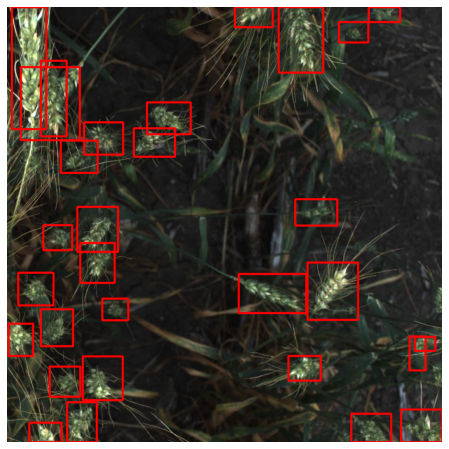

In [ ]:
boxes = targets[7]['boxes'].cpu().numpy().astype(np.int32)
sample = images[7].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    print('bounding box: ',box[0],' ',box[1],' ',box[2],' ',box[3])
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

### Train model

Load pretrain model Faster RCNN 

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 2 # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Sử dụng optimizer là SGD với learning rate là 0.005, momentum là 0.9. Train model với 5 epoch.

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 5

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

Iteration #50 loss: 0.7778456211090088
Iteration #100 loss: 0.8015544414520264
Iteration #150 loss: 0.7533363103866577
Iteration #200 loss: 0.6120207905769348
Iteration #250 loss: 0.6135402917861938
Iteration #300 loss: 0.5727129578590393
Epoch #0 loss: 0.7687448904050135
Iteration #350 loss: 0.5938870906829834
Iteration #400 loss: 0.6390718817710876
Iteration #450 loss: 0.7070532441139221
Iteration #500 loss: 0.4746868312358856
Iteration #550 loss: 0.6824665665626526
Iteration #600 loss: 0.5069714188575745
Iteration #650 loss: 0.6972763538360596
Epoch #1 loss: 0.6678072478743078
Iteration #700 loss: 0.6632639169692993
Iteration #750 loss: 0.6818280220031738
Iteration #800 loss: 0.6960794925689697
Iteration #850 loss: 0.42464086413383484
Iteration #900 loss: 0.4941651225090027
Iteration #950 loss: 0.4328632354736328
Iteration #1000 loss: 0.5572948455810547
Epoch #2 loss: 0.6454897491277847
Iteration #1050 loss: 0.7433971762657166
Iteration #1100 loss: 0.6545853018760681
Iteration #1150

### Test

Test thử kết quả trên model đã train với tập valid.

Plot bounding box của hạt lúa mì trên ảnh từ tập valid.

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image:  18


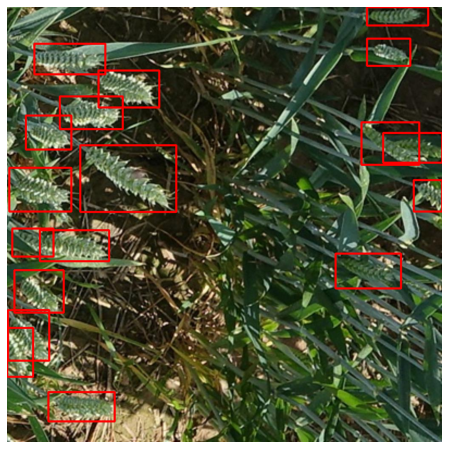

In [ ]:
boxes = targets[5]['boxes'].cpu().numpy().astype(np.int32)
sample = images[5].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print ("Total bounding box of image: ",len(boxes))
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

Sử dụng model đã train để predict ra bounding box của ảnh trên tập valid.

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
detection_threshold = 0.7
sample_ = images[5].permute(1,2,0).cpu().numpy()
boxes_ = outputs[5]['boxes'].data.cpu().numpy()
scores_ = outputs[5]['scores'].data.cpu().numpy()

boxes_ = boxes_[scores_ >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image (predict):  19
bounding box:  212   145   354   239
bounding box:  25   630   132   730
bounding box:  121   212   272   292
bounding box:  844   1   982   50
bounding box:  5   389   150   480
bounding box:  39   267   152   343
bounding box:  825   276   999   381
bounding box:  104   907   257   978
bounding box:  175   322   383   477
bounding box:  852   82   949   139
bounding box:  959   407   1024   487
bounding box:  52   91   226   163
bounding box:  778   581   927   657
bounding box:  8   726   102   840
bounding box:  18   520   242   607
bounding box:  0   758   56   872
bounding box:  906   301   1022   364
bounding box:  10   860   98   930
bounding box:  3   51   114   105


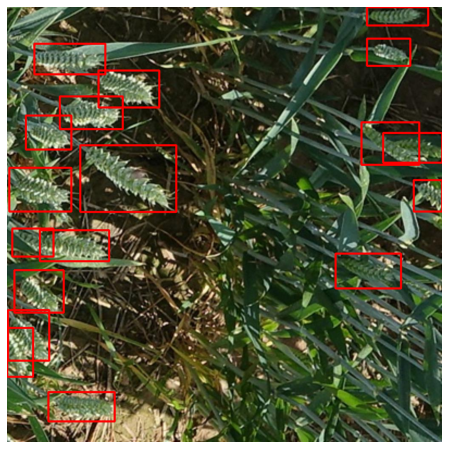

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print ("Total bounding box of image (predict): ",len(boxes_))
for box in boxes_:
    print('bounding box: ',box[0],' ',box[1],' ',box[2],' ',box[3])
    cv2.rectangle(sample_,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)